# Сеть фитнес-центров «Культурист-датасаентист»  

**Цель проекта:** - провести анализ и подготовить план действий по удержанию клиентов сети фитнес-центров «Культурист-датасаентист».  

**Имеющиеся данные**  
- "сырые" данные о посетителях фитнес-центра (ключевые: возраст, пол, длительность текущего абонемента, пользование дополнительными услугами и другие).  

**Ход исследования**  
- изучение и предобработка данных.
- проведение исследовательского анализа данных.
- построение модели прогнозирования оттока клиентов.
- кластеризация клиентов.
- выводы по проекту.


## Загрузка и предобработка DF

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
local_path = "./"
server_path = "/datasets/"
file = "gym_churn.csv"
try:
    data_gym = pd.read_csv(f"{local_path}{file}")
except:
    data_gym = pd.read_csv(f"{server_path}{file}")

In [4]:
data_gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пустых значений нет ни в одном столбце, типы данных соответствуют содержимому.

Названия столбцов написаны в большинстве с большой буквы, что не очень удобно для использования. Приведем все к одному варианту написания.

In [5]:
data_gym.columns = [x.lower() for x in data_gym.columns]

Посмотрим по столбцам варианты значений:

In [6]:
for c in data_gym.columns:
    print(c, "\n")
    print(data_gym[c].value_counts())
    print(" " * 30)

gender 

1    2041
0    1959
Name: gender, dtype: int64
                              
near_location 

1    3381
0     619
Name: near_location, dtype: int64
                              
partner 

0    2053
1    1947
Name: partner, dtype: int64
                              
promo_friends 

0    2766
1    1234
Name: promo_friends, dtype: int64
                              
phone 

1    3614
0     386
Name: phone, dtype: int64
                              
contract_period 

1     2207
12     960
6      833
Name: contract_period, dtype: int64
                              
group_visits 

0    2351
1    1649
Name: group_visits, dtype: int64
                              
age 

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64
                              
avg_additional_charges_total 

Варианты представления данных по всем столбцам корректны, задвоеных, ошибочных написаний не содержится. Изучения данных по столбцам на предмет выбросов будут произведены позднее.

Проверим наличие явных дубликатов

In [7]:
data_gym.duplicated().sum()

0

**Вывод**  
DF состоит из 4000 строк и 14 столбцов, не содержит пропущенных значений и дубликатов. Данные можно считать достаточно качественными.

## Исследовательский анализ данных (EDA)

### Изучение показателей
Для числовых небинарных столбцов изучим значения показателей - средние значения, стандартное отклонение, квантили. Для этого выделим в отдельную переменную имена этих столбцов, они будут признаками по которым в дальнейшем станем производить анализ.

In [8]:
attrs = data_gym.columns[[7, 5, 8, 9, 10, 11, 12]].to_list()

attrs_dict = {
    "age": "возраст",
    "avg_additional_charges_total": "выручка от прочих услуг фитнес-центра",
    "month_to_end_contract": "срок до окончания текущего действующего абонемента",
    "lifetime": "время с момента первого обращения в фитнес-центр ",
    "avg_class_frequency_total": "средняя частота посещений в неделю за все время",
    "avg_class_frequency_current_month": "средняя частота посещений в неделю за предыдущий месяц",
    "contract_period": "длительность текущего действующего абонемента",
}

In [9]:
for a in attrs:
    print(a, "\n")
    print(data_gym[a].describe())
    print(" " * 30)

age 

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64
                              
contract_period 

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64
                              
avg_additional_charges_total 

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64
                              
month_to_end_contract 

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float

Столбец возраст (age) среднее значение 29.18, стандартное отклонение 3.26, разброс значений слабый от 18 до 41.

Столбец длительность текущего действующего абонемента (contract_period) среднее значение 4.68, стандартное отклонение 4.54, значение третьего квантиля составляет 6 месяцев - только четверть всех посетителей пребретают абонементы на период превышающий эту цифру. 

Столбец суммарная выручка от дополнительных услуг фитнес-центра (avg_additional_charges_total) среднее значение 146.94, стандартное отклонение 96.36, разброс сильный от 0.15 до 552.59.

Столбец срок до окончания текущего действующего абонемента (month_to_end_contract) среднее значение 4.32, стандартное отклонение 4.19, разброс значений слабый, 3/4 приобретенных абонементов с остаточным сроком меньше 6 месяцев.

Столбец время с момента первого обращения в фитнес-центр в месяцах (lifetime) среднее значение 3.72, стандартное отклонение 3.74, разброс значений сильный от 0 до 31, третий квантиль при этом равен 5.

Столбец средняя частота посещений в неделю за все время с начала действия абонемента (avg_class_frequency_total) среднее значение 1.88, стандартное отклонение 0.97, разброс значений сильный от 0 до 6.0.

Столбец средняя частота посещений в неделю за предыдущий месяц (avg_class_frequency_current_month) среднее значение 1.77, стандартное отклонение 1.05, разброс значений сильный от 0 до 6.14.

### Средние значения показателей в группировке признака 'churn'
Далее рассмотрим значение средних значений признаков, разделив пользователей по колонке 'churn' - отток в текущем месяце.

In [10]:
group_attr = data_gym.groupby("churn")[attrs].mean()
group_attr

,age,contract_period,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,29.976523,5.747193,158.445715,5.283089,4.711807,2.024876,2.027882
1,26.989632,1.728558,115.082899,1.662582,0.990575,1.474995,1.044546


Все средние значения показателей в каждой из групп отличаются:  
    -  возраст ушедших пользователей ниже, чем продолживших пользование;  
    - срок действия абонемента оставшихся пользователей в 3 раза больше, чем у ушедших;  
    - траты на доп. услуги у ушедших пользователей ниже, чем продолживших пользование;  
    - оставшийся срок до окончания действия абонемента ушедших пользователей меньше, чем продолживших пользование;  
    - время с момента первого обращения ушедших пользователей меньше, чем продолживших пользование;  
    - средняя частота посещений в неделю (оба показателя и за все время посещения и за предыдущий месяц) ушедших пользователей меньше, чем продолживших пользование

### Cтолбчатые гистограммы и распределения признаков для ушедших и оставшихся пользователей

In [11]:
def get_hist_plot(df, atr, ax):
    sns.set_palette("deep")
    sns.histplot(
        df[atr][df["churn"] == 0],
        label="остался",
        color="blue",
        alpha=0.7,
        ax=ax,
        legend=True,
    )

    sns.histplot(
        df[atr][df["churn"] == 1],
        label="ушел",
        color="magenta",
        alpha=0.5,
        ax=ax,
        legend=True,
    )

In [12]:
len(attrs), attrs

(7,
 ['age',
  'contract_period',
  'avg_additional_charges_total',
  'month_to_end_contract',
  'lifetime',
  'avg_class_frequency_total',
  'avg_class_frequency_current_month'])

In [13]:
# for a in attrs:
#     get_hist_plot(data_gym, a)
#     print(30 * "")

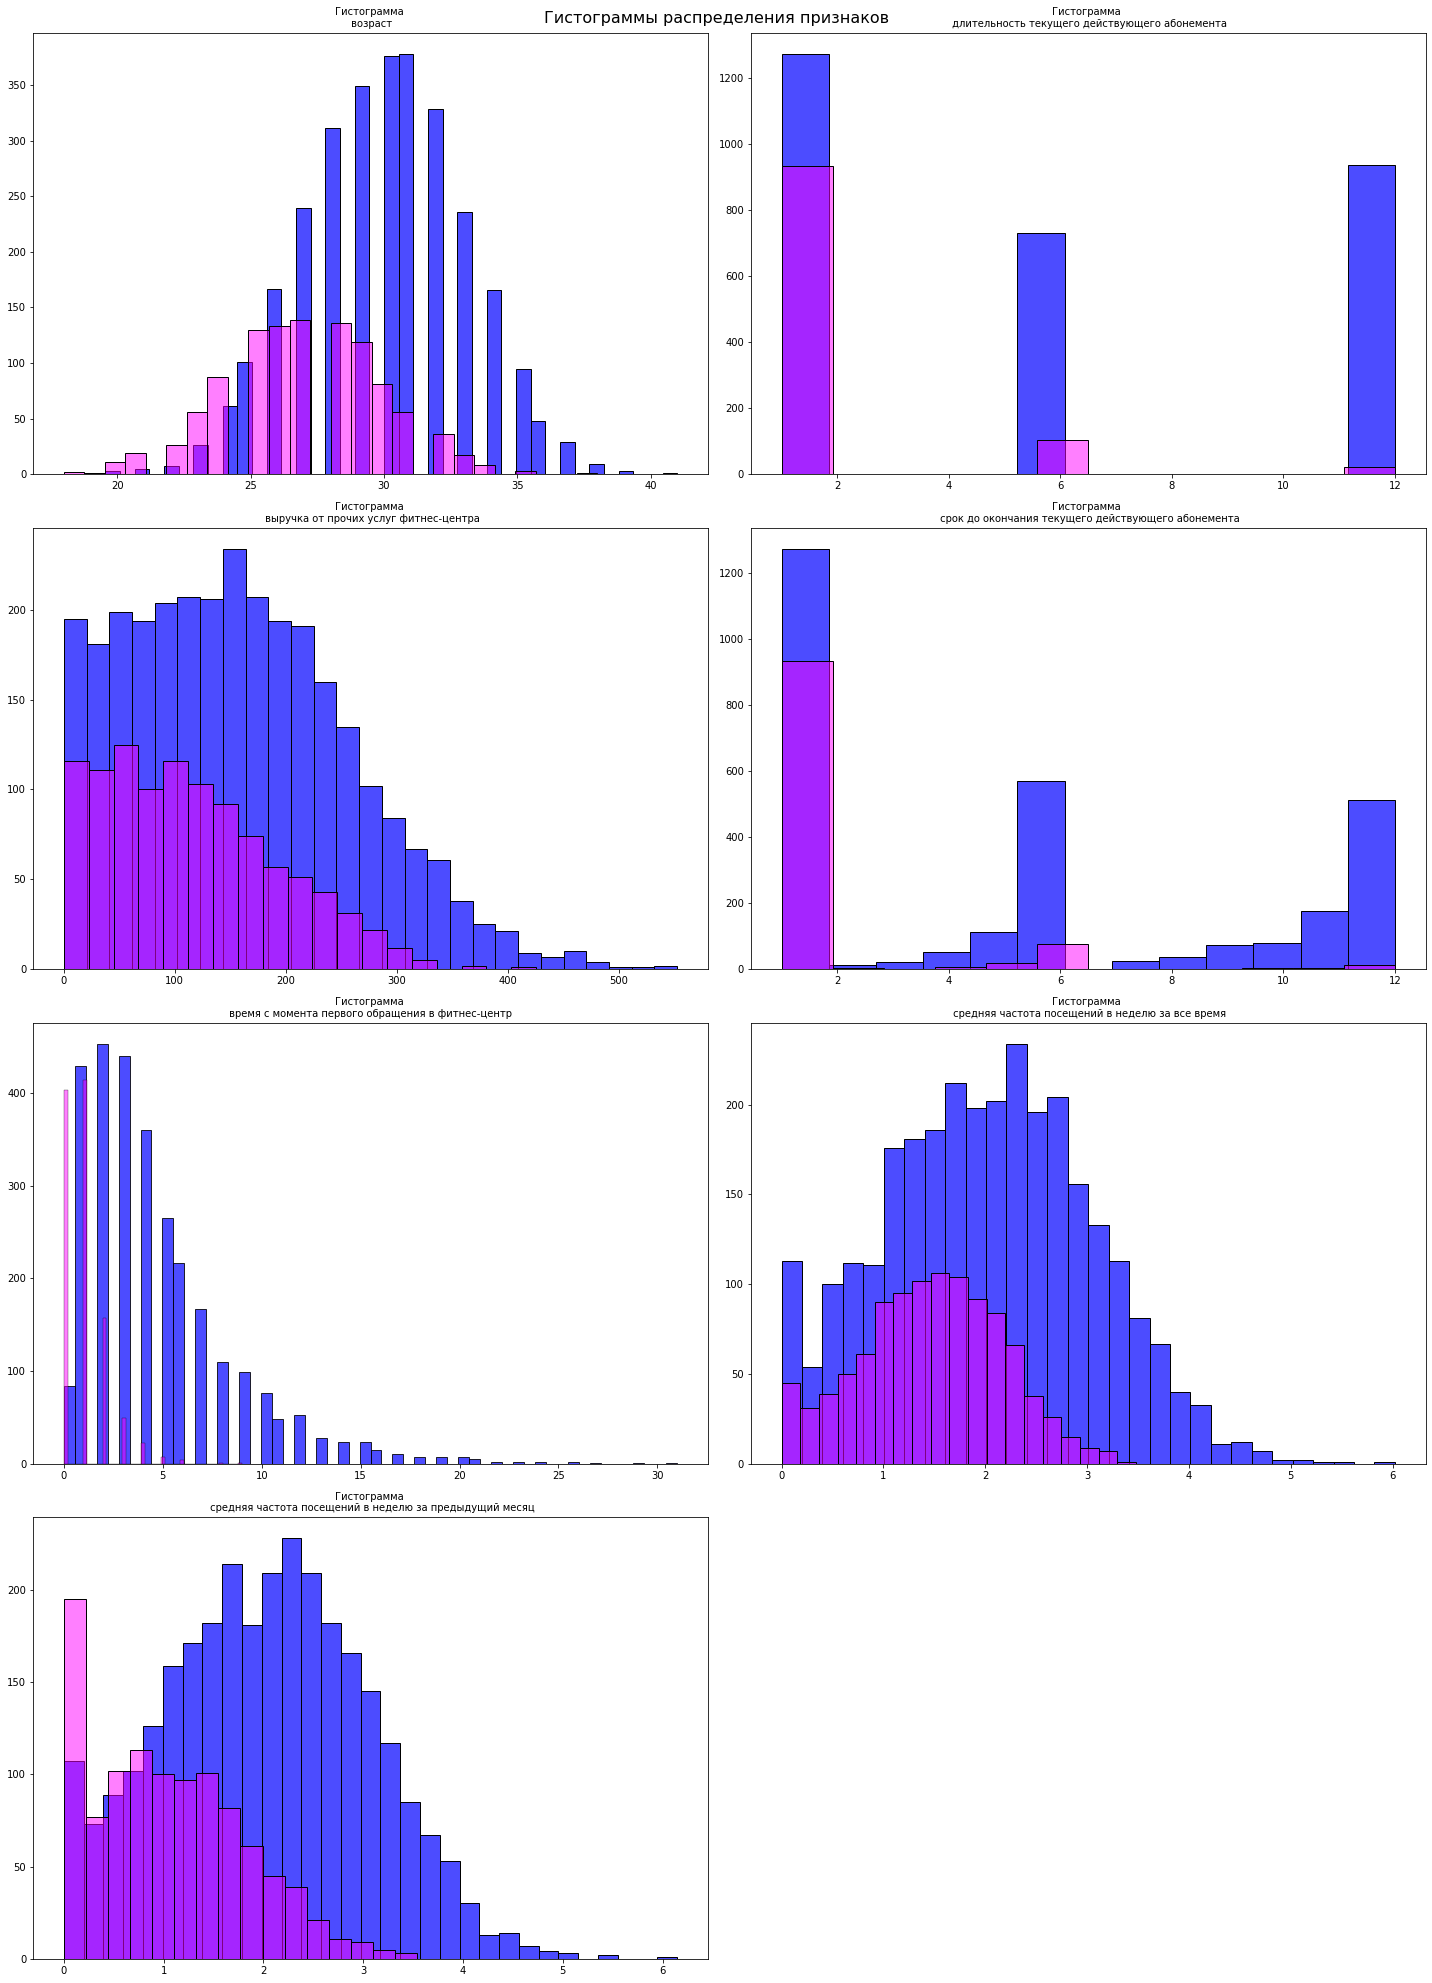

In [14]:
num_c = 2
if len(attrs) % 2 == 0:
    num_r = len(attrs) // 2
else:
    num_r = len(attrs) // 2 + 1

fig, ax = plt.subplots(
    nrows=num_r,
    ncols=num_c,
    figsize=(20, 28),
)
fig.suptitle("Гистограммы распределения признаков", size=16)
for a in attrs:
    row = attrs.index(a) // num_c
    col = attrs.index(a) % num_c
    get_hist_plot(data_gym, a, ax[row, col])
    ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel("")
    ax[row, col].set_title(f"Гистограмма \n {attrs_dict[a]}", size=10)
fig.delaxes(ax[3, 1])
plt.tight_layout()

По построенным гистограммам анализируемых признаков можно заметить следующие особенности:  
- пик возраста у оставшихся пользователей приходится на период 28-32 года, в то время как у ушедших 25-29. Значения возрастов распределены нормально;  
- по количеству оставшихся месяцев пользования абонементом абсолютный лидер у обех групп 1 месяц, однако у оставшихся на втором месте 11-12 месяцев, на третьем 5-6 месяцев. У ушедших пользователей все значения кроме 1 представлены крайне слабо;
- суммы выручки от прочих услуг по обеим группам сильно скошены влево (к нулевому значению). Пик суммарной выручки по оставшимся посетителям составляет порядка 150-160 единиц, по ушедшим - 50-60 единиц;  
- наиболее часто встречающееся значения остатка срока действия абонемента у обеих групп посетителей 1 месяц, у продолжающих пользоваться услугами фитнес-центра также хорошо заметны пики на уровне 6 и 12 месяцев, но менее выраженные. У ушедших пользователей незначительный пик в районе 6 месяцев;  
- продолжительность пользования абонементом у ушедших пользователей ярко выражена пиками 1-2 месяц, далее количество значений резко снижается. У пользователей продолжающих посещения наиболее частые значения 2-5 месяцев, после 20 встречаются единичные выбросы;  
- частота посещений в неделю за все время у ушедших пользователей распределена относительно нормально, со слабо выраженым пиком в промежутке между 1 и 2 посещениями. У оставшихся пользователей основной пик на значении 2,4 посещения и два меньших на 1,8 и 2,8. У обеих групп явно выражен подъем в районе значения 0;  
- частота посещений в неделю за предыдущий месяц у оставшихся пользователей распределена относительно нормально с двумя пиками в значениях 1,7 и 2,2. У ушедших максимум значений в районе отметки 0, далее популярные частоты посещения сосредоточены в диапазоне 0,6-1,8. 

In [15]:
def get_box_plot(df, atr, ax):
    sns.boxplot(
        x=df["churn"],
        y=df[atr],
        palette="hls",
        medianprops=dict(color="yellow", alpha=0.7),
        ax=ax,
    )
    plt.xlabel("остался / ушел")
    plt.title(f"Распределение \n {attrs_dict[atr]}")
    plt.grid()
    # plt.show()

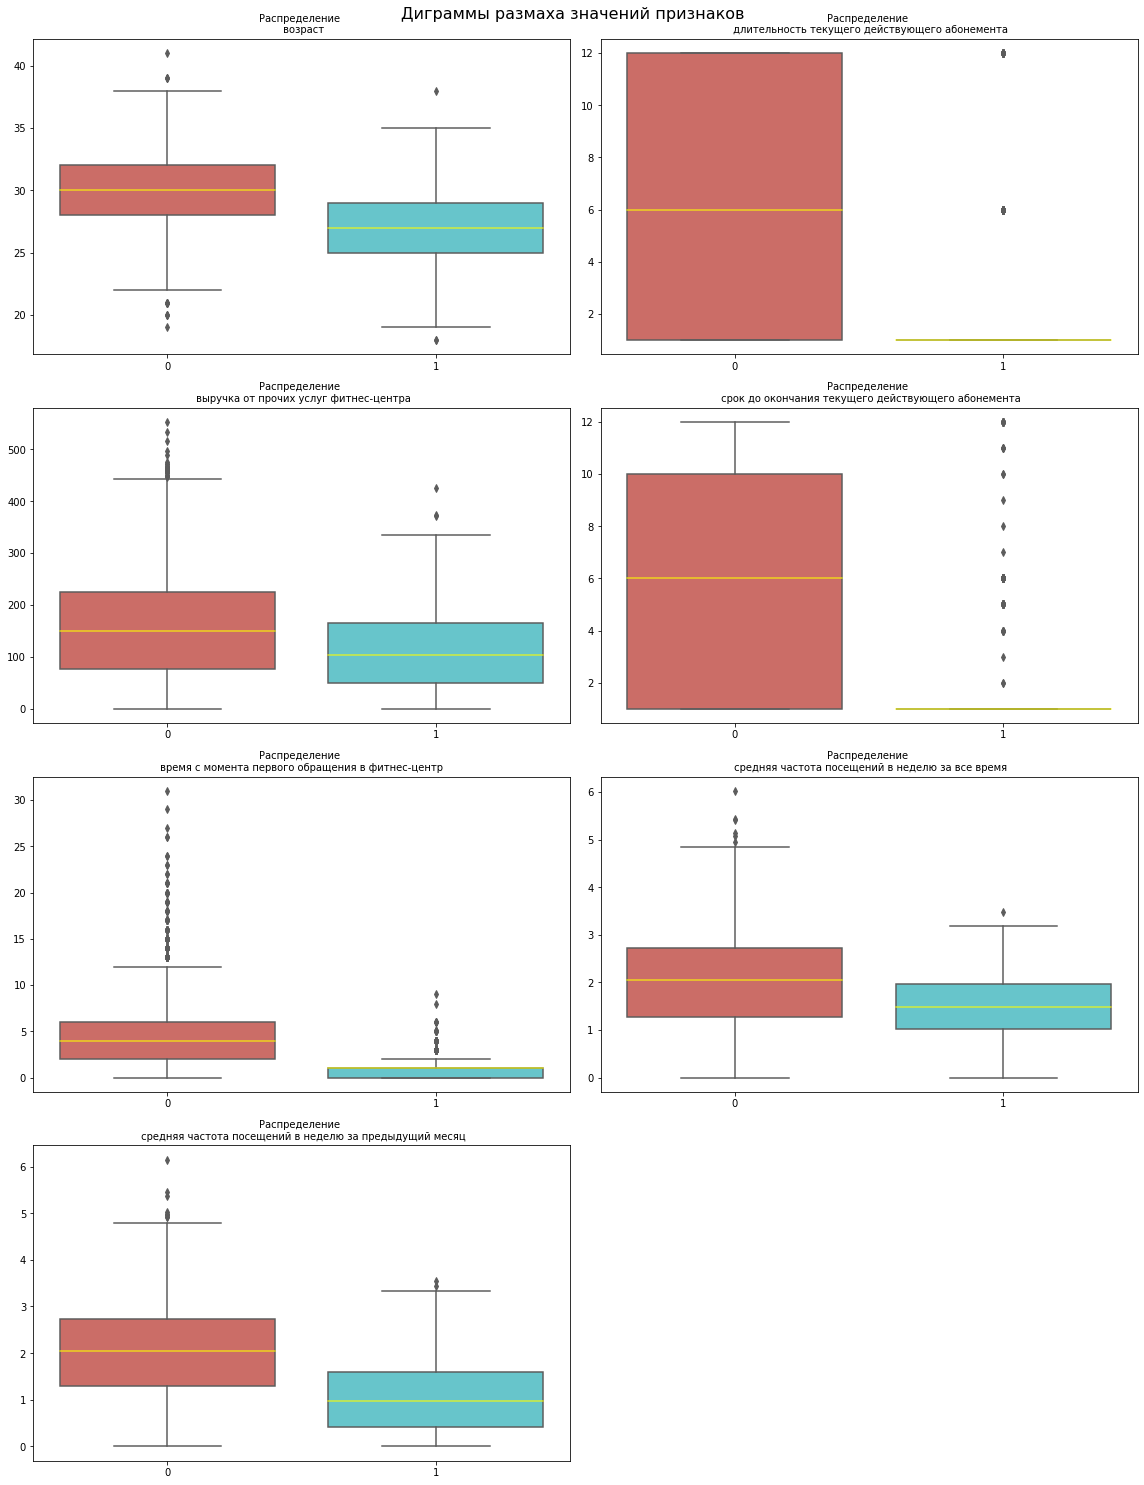

In [16]:
num_c = 2
if len(attrs) % 2 == 0:
    num_r = len(attrs) // 2
else:
    num_r = len(attrs) // 2 + 1

fig, ax = plt.subplots(
    nrows=num_r,
    ncols=num_c,
    figsize=(16, 21),
)
fig.suptitle("Диграммы размаха значений признаков", size=16)
for a in attrs:
    row = attrs.index(a) // num_c
    col = attrs.index(a) % num_c
    get_box_plot(data_gym, a, ax[row, col])
    ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel("")
    ax[row, col].set_title(f"Распределение \n {attrs_dict[a]}", size=10)
fig.delaxes(ax[3, 1])
plt.tight_layout()

In [17]:
# for a in attrs:
#     get_box_plot(data_gym, a)
#     print(30*"")

По построенным диаграммам рассеяния исследуемых признаков можно заметить следующие особенности:  
- медиана возраста у оставшихся пользователей приходится на 30 лет, у ушедших на 27. Значения возрастов распределены нормально, небольшие выбросы у обеих групп с двух строн (максимума и минимума);  
- по количеству оставшихся месяцев пользования абонементом у оставшихся пользователей значения распределены нормально от 1 до 12, с медианой на уровне 6. У ушедших пользователей все значения кроме 1 представлены крайне слабо, единичные выбросы на уровне 6 месяцев;
- суммы выручки от прочих услуг по оставшимся посетителям медианное значение составляет порядка 150 единиц, большая часть значений смещена к четвертому квартилю, наблюдается выбросы выше максимума. По ушедшим пользователям медианное значение составляет 100 единиц и также как и у оставшихся большая часть значений смещена к четвертому квартилю, наблюдается выбросы выше максимума;  
- значения остатка срока действия абонемента у продолжающих пользоваться услугами фитнес-центра распределены нормально, медиана - 6 месяцев. У ушедших пользователей медиана и основная доля значений представлена 1 месяцем, остальные значения - это единичные выбросы;  
- продолжительность пользования абонементом у ушедших пользователей основная часть значений ниже медианы 1 месяц с выбросами выше макмсимума. У пользователей продолжающих посещения медиана на уровне 4 месяцев, значения смещены к 4 квартилю, множественные выбросы выше него;  
- частота посещений в неделю за все время у ушедших пользователей распределена относительно нормально, с медианным значением 1,5 посещения. У оставшихся пользователей медианное значение 2 посещения, распределение несколько смещено к верхнему краю;  
- частота посещений в неделю за предыдущий месяц у оставшихся пользователей распределена относительно нормально со смещением к верхнему краю и медианой 2. У ушедших также наблюдается смещение к верхнему краю и незначительное число выбросов выше него, медианное значение равно 1. 

### Матрица корреляции признаков

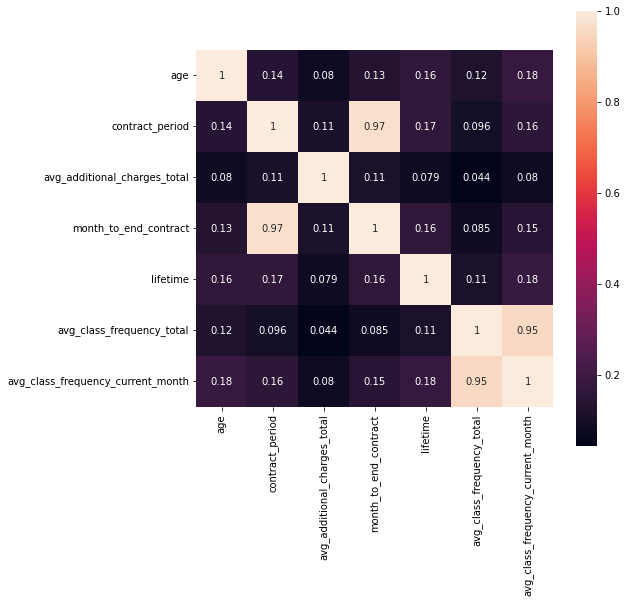

In [18]:
corr_m = data_gym[attrs].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_m, square=True, annot=True)
plt.show()

Между собой плотно коррелируют только 2 признака  - avg_class_frequency_total и avg_class_frequency_current_month, а также contract_period и month_to_end_contract. Коэффициент корреляции составляет 0.95 и 0.97 соответственно. У остальных признаков такой сильной зависимости между собой не наблюдается.  
Признаки с мультиколлинеарностью в целях дальнейшего анализа удалять не будем, т.к. далее будем использовать методы обучения модели "случайный лес" (этот метод не подвержен влиянию мультиколлинеарности) и "логистическую регрессию" (в параметрах автоматически применяется метод регуляризации l2 - Ridge-регрессия. Ошибки минимизируются подбором оптимальных весов и дополнительно минимизацией суммы квадратов этих весов).

## Построение модели прогнозирования оттока клиентов

### Формирование обучающей и валидационной выборок, обучение модели, анализ метрик модели
Целевым признаком при построении модели бинарной классификации клиентов выберем факт оттока клиента в следующем месяце ('churn').

In [19]:
X = data_gym.drop(columns=["churn"])
y = data_gym["churn"]

Получим обучающую и валидационные выборки

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Модель будем обучать двумя способами: логистической регрессией и случайным лесом, предварительно стандартизируем наши данные.

In [21]:
models = [LogisticRegression(solver="liblinear"), RandomForestClassifier()]

In [22]:
scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [23]:
def get_pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train_st, y_train)
    predictions = m.predict(X_test_st)
    print(
        f"Accuracy: {accuracy_score(y_test, predictions):.2f}, Precision: {precision_score(y_test, predictions):.2f}, Recall: {recall_score(y_test, predictions):.2f}"
    )

In [24]:
for m in models:
    print(m)
    get_pred(m, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(solver='liblinear')
Accuracy: 0.92, Precision: 0.85, Recall: 0.83
RandomForestClassifier()
Accuracy: 0.92, Precision: 0.85, Recall: 0.80


Изучим полученые метрики классификации.  

Доля верных прогнозов (Accuracy) в зависимости от метода отличается незначительно, метод логистическая регрессия дал равный показатель, как и случайный лес.  
Доля правильных ответов только среди целевого класса (Precision) на 1 пп выше у метода логистическая регрессия.  
Доля обнаружения реальных объектов целевого класса (Recall) также на 2 пп выше  у метода логистическая регрессия.  

Можно сделать вывод, что метод  логистической регрессии незначительно, но лучше метода случайного леса.

In [25]:
for m in models:
    print(m)
    get_pred(m, X_train, y_train, X_test, y_test)

LogisticRegression(solver='liblinear')
Accuracy: 0.92, Precision: 0.85, Recall: 0.83
RandomForestClassifier()
Accuracy: 0.91, Precision: 0.84, Recall: 0.81


На нестандертизированых данных получаем также близкие результаты.

### Кластеризация клиентов

#### Построение дендограммы

In [26]:
ssc = StandardScaler()
X_ssc = ssc.fit_transform(X)

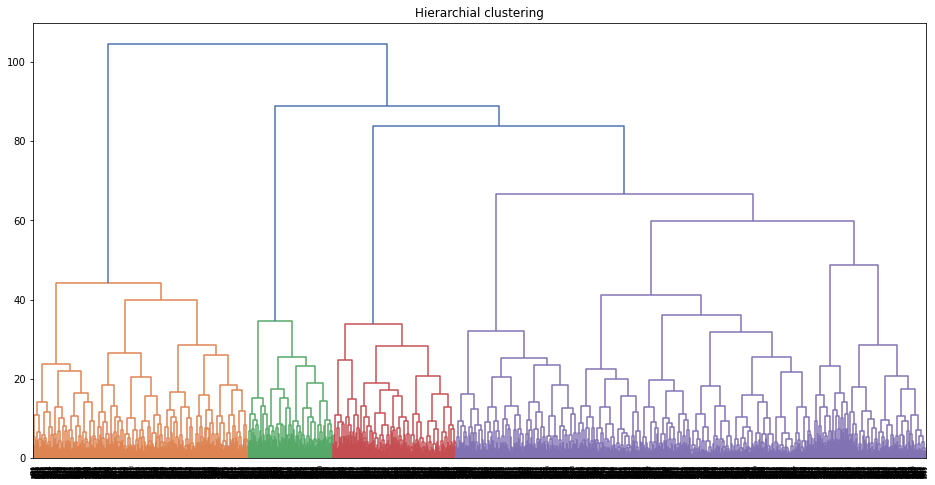

In [27]:
linked = linkage(X_ssc, method="ward")
plt.figure(figsize=(16, 8))
dendrogram(linked, orientation="top")
plt.title("Hierarchial clustering")
plt.show()

По построенной дендограмме можно определить оптимальное число кластеров 4.

#### Кластеризация методом k-средних(k-means)

In [28]:
# по дендограмме число кластеров определили как 4, по бизнес требованию оно указано как 5
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_ssc)
data_gym["cluster_churn"] = labels

In [29]:
data_gym.groupby("cluster_churn").mean().T

cluster_churn,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Изучая средние значения признаков по кластерам можно заметить следующее:  
- по полу деление на кластеры равномерное, полы 1 и 0 в каждом из них представлены в равной мере;
- близость фитнес-центра к значимой для посетителя локации (дом/работа) послужила признаком для выделения одного кластера с "чистым" значением 0, так же как и признак телефон;
- признаки  партнерство организации и "приведи" тоже не стало разделеяющим признаком для кластеров;
- по времени действия текущего абонемента два из пяти кластеров в значительной мере отличаются от других, также и по сроку действия абонемента;
- разделяющим признаком в значительнойо мере можно считать факт оттока - значение по всем кластерам в значительной мере отличаются друг от друга.

In [30]:
def plot_clusters(df, ax_x, ax_y, cluster):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=df, x=df[ax_x], y=df[ax_y], hue=df[cluster], palette="Set2")
    plt.title(f"{ax_x} vs { ax_y}")
    plt.show()

In [31]:
col_pairs = list(
    itertools.combinations(data_gym.drop("cluster_churn", axis=1).columns, 2)
)

In [32]:
col_pairs

[('gender', 'near_location'),
 ('gender', 'partner'),
 ('gender', 'promo_friends'),
 ('gender', 'phone'),
 ('gender', 'contract_period'),
 ('gender', 'group_visits'),
 ('gender', 'age'),
 ('gender', 'avg_additional_charges_total'),
 ('gender', 'month_to_end_contract'),
 ('gender', 'lifetime'),
 ('gender', 'avg_class_frequency_total'),
 ('gender', 'avg_class_frequency_current_month'),
 ('gender', 'churn'),
 ('near_location', 'partner'),
 ('near_location', 'promo_friends'),
 ('near_location', 'phone'),
 ('near_location', 'contract_period'),
 ('near_location', 'group_visits'),
 ('near_location', 'age'),
 ('near_location', 'avg_additional_charges_total'),
 ('near_location', 'month_to_end_contract'),
 ('near_location', 'lifetime'),
 ('near_location', 'avg_class_frequency_total'),
 ('near_location', 'avg_class_frequency_current_month'),
 ('near_location', 'churn'),
 ('partner', 'promo_friends'),
 ('partner', 'phone'),
 ('partner', 'contract_period'),
 ('partner', 'group_visits'),
 ('partner'

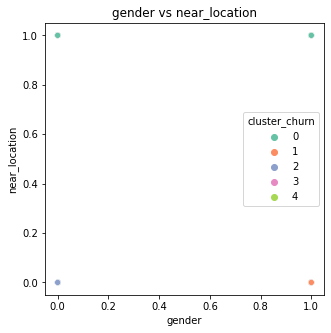

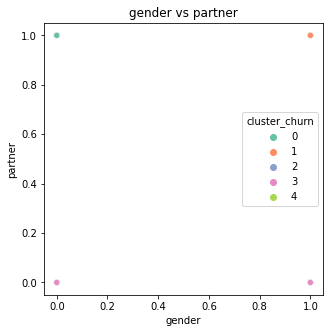

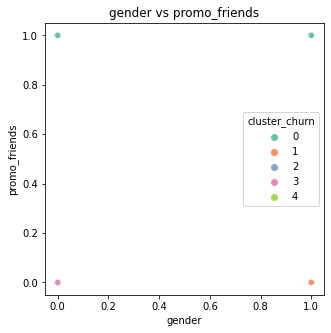

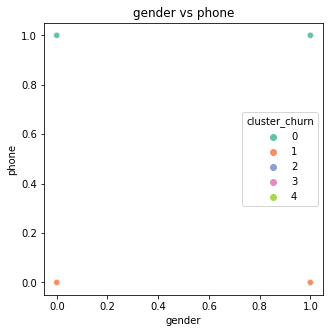

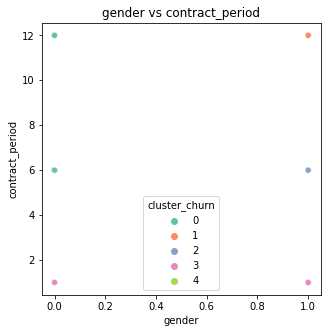

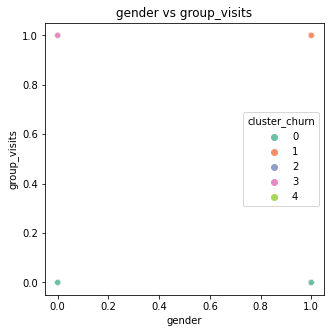

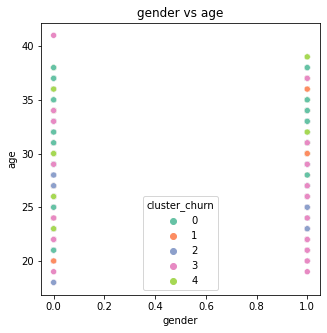

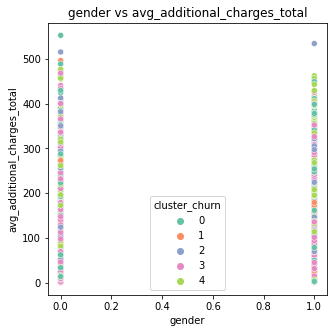

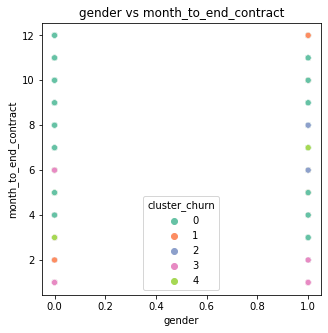

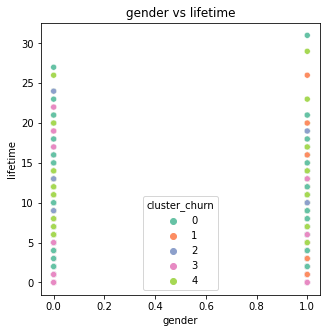

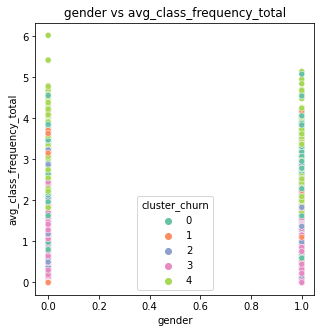

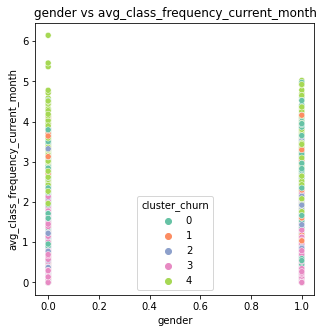

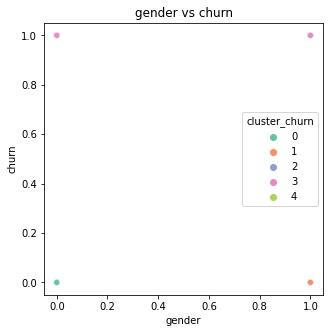

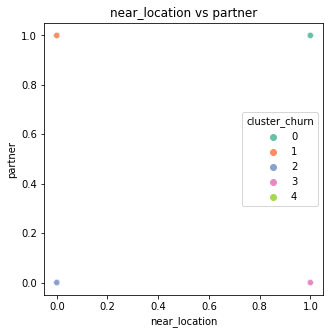

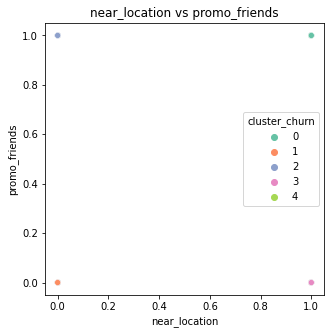

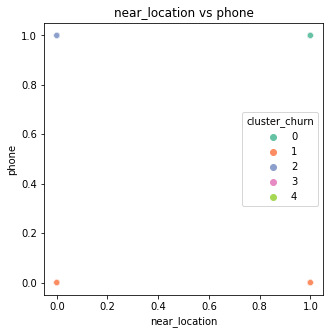

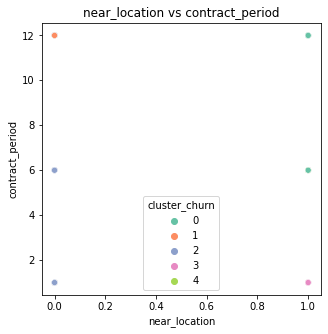

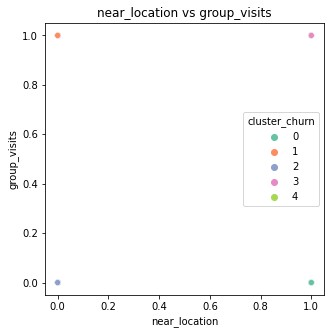

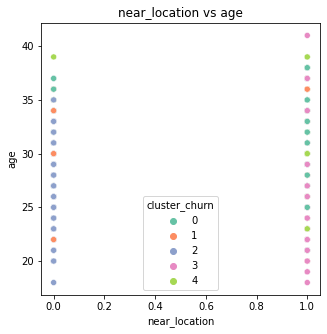

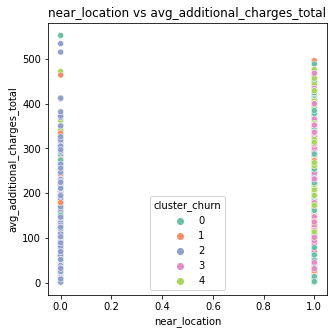

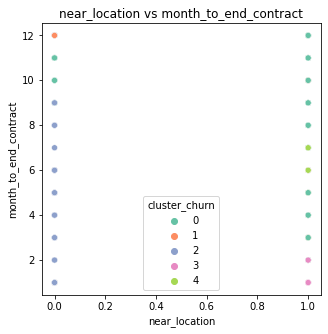

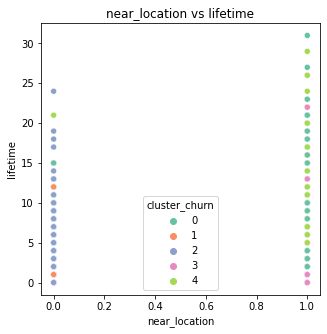

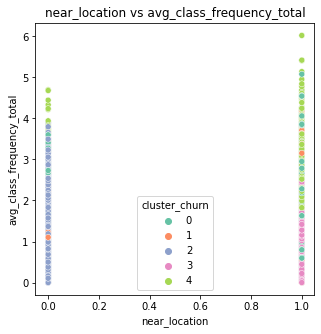

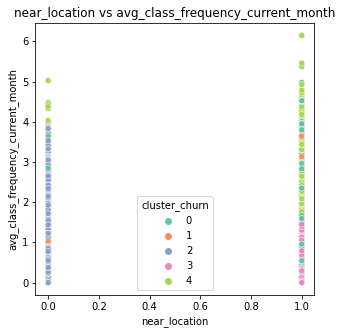

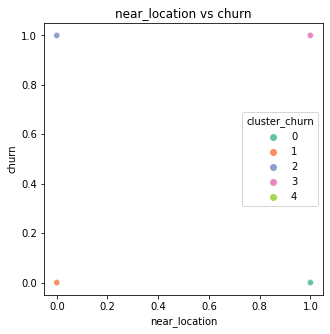

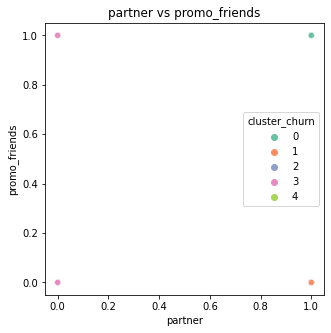

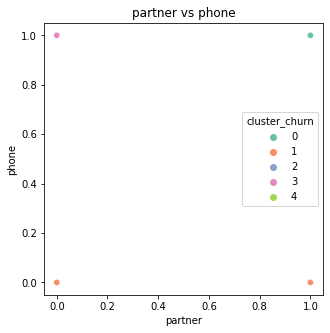

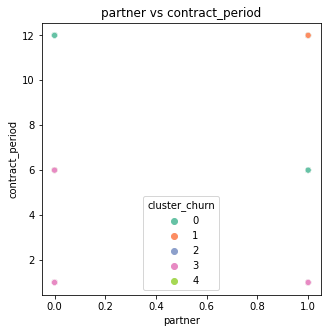

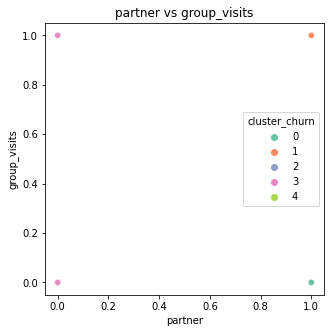

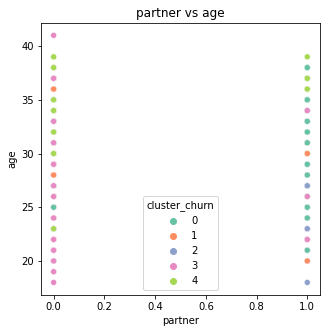

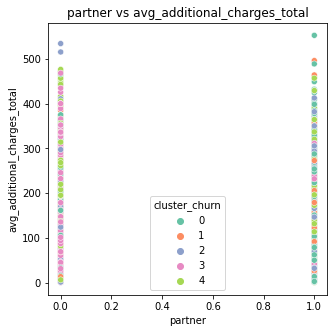

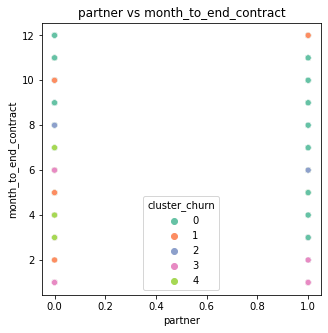

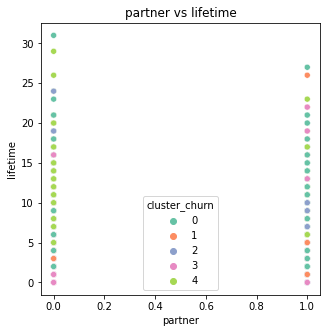

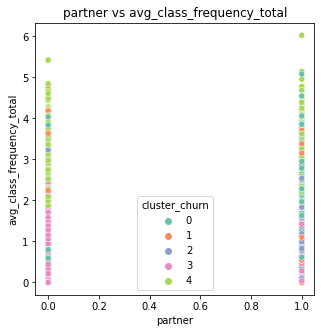

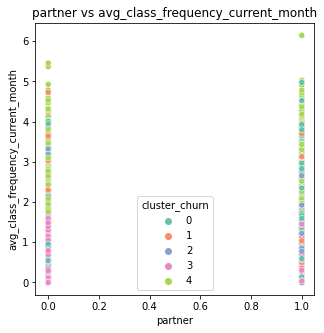

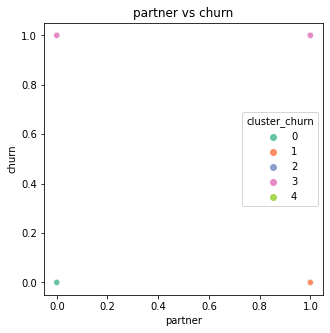

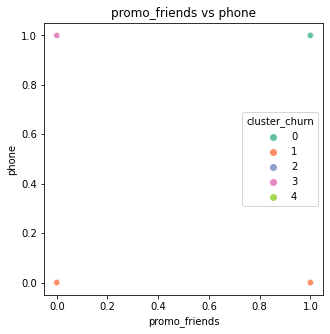

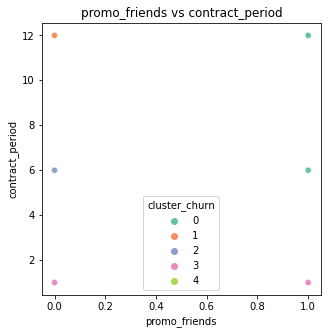

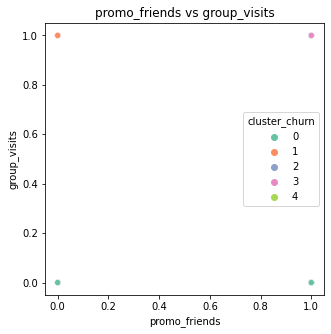

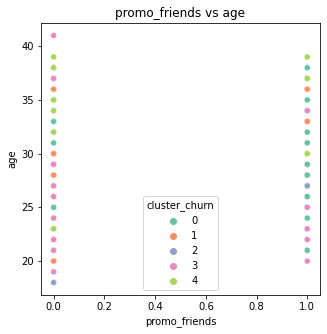

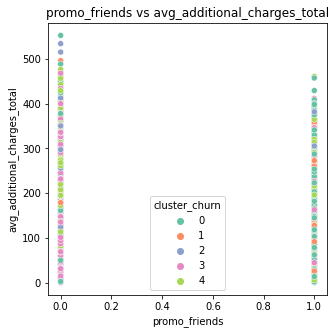

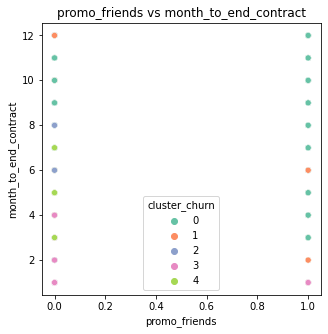

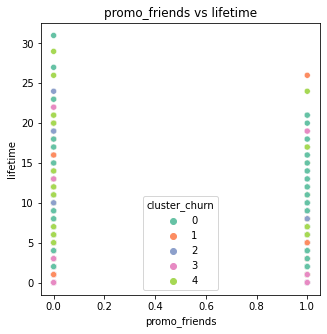

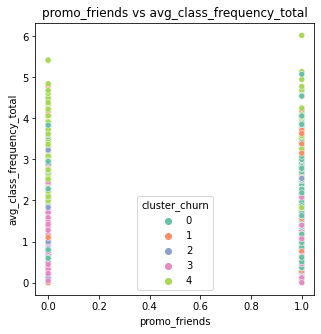

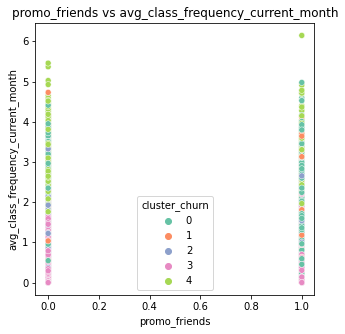

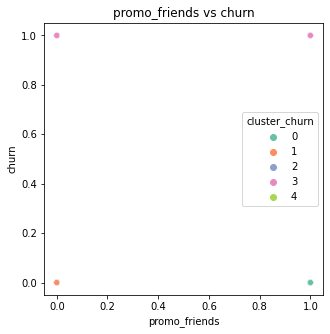

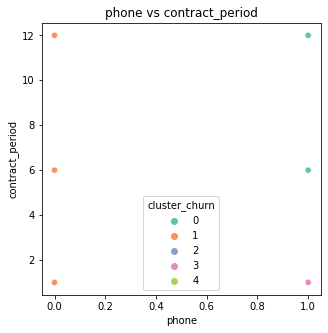

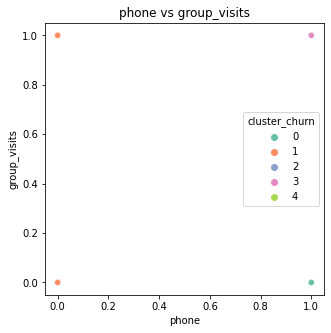

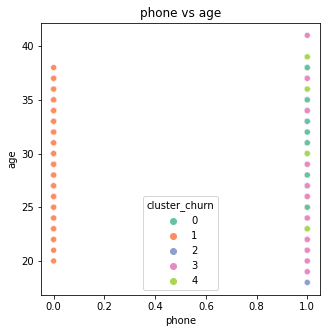

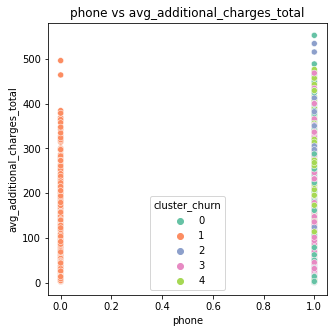

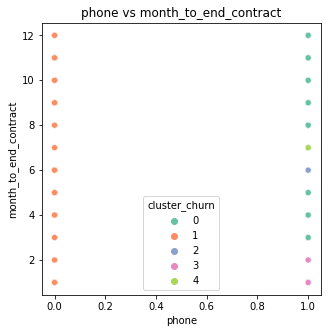

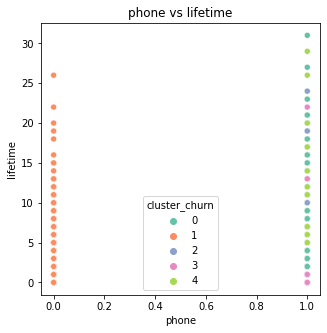

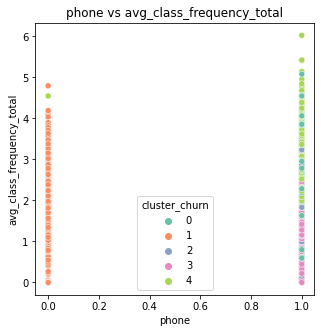

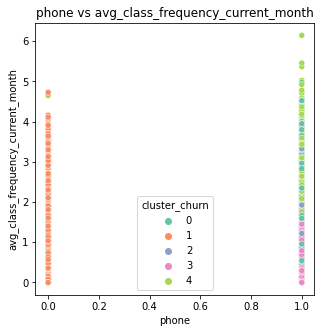

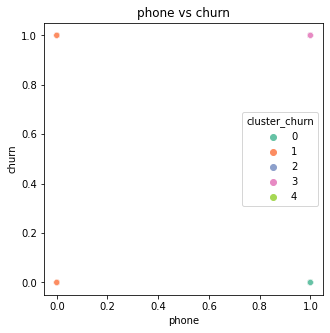

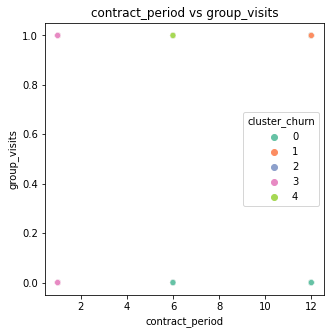

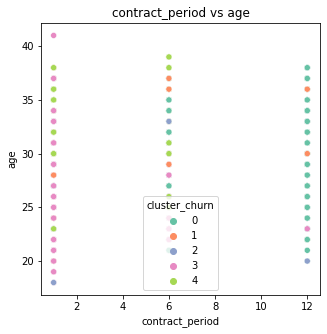

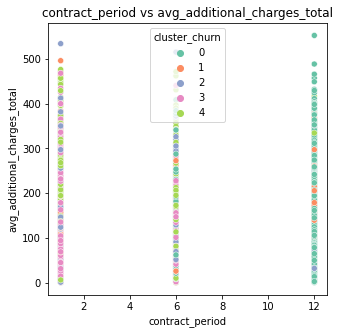

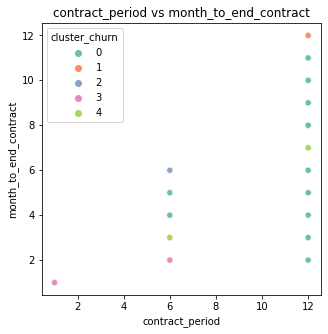

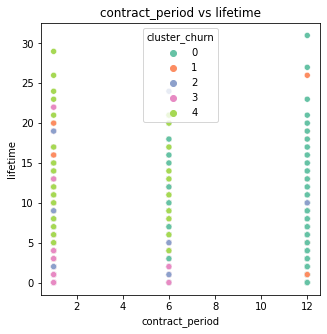

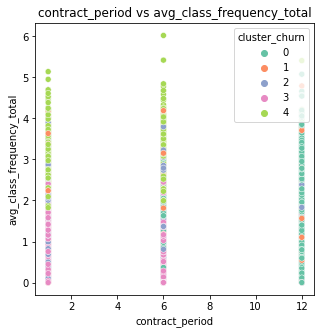

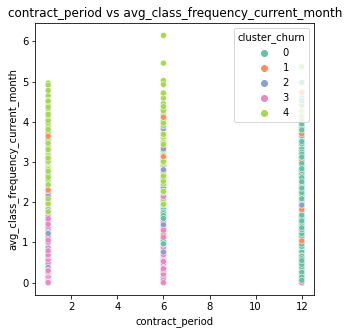

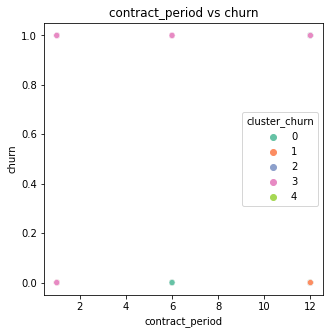

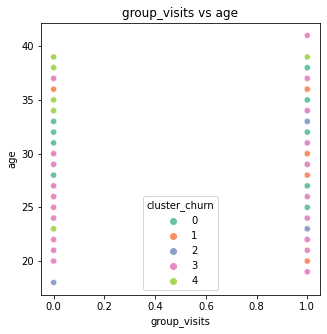

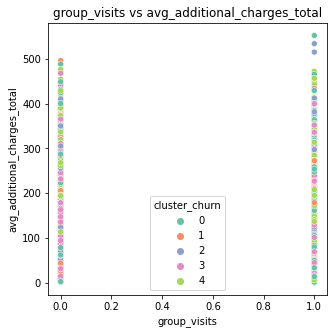

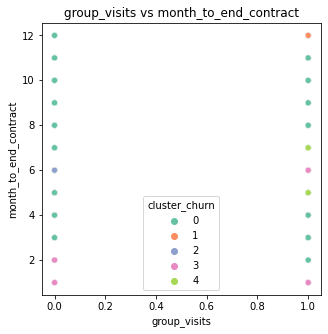

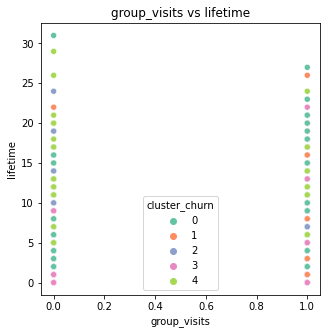

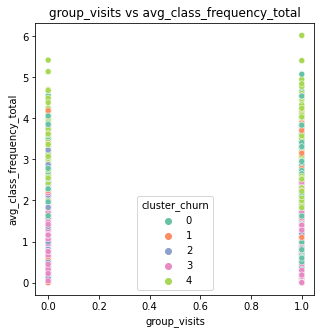

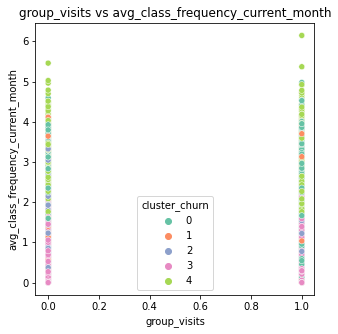

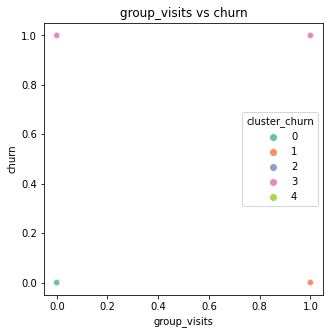

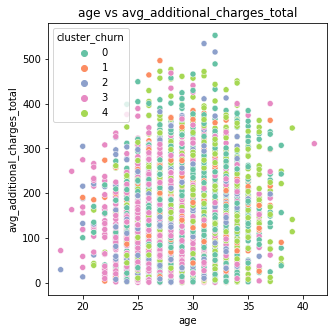

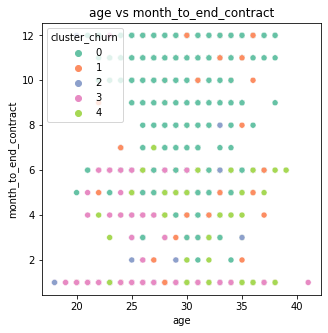

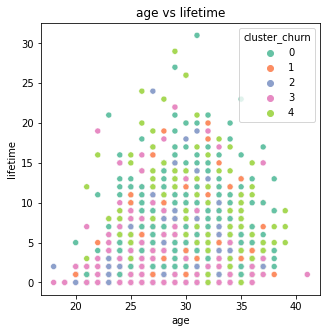

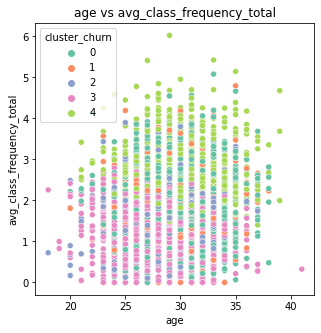

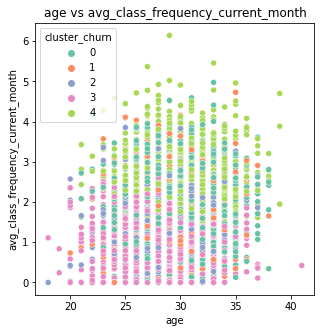

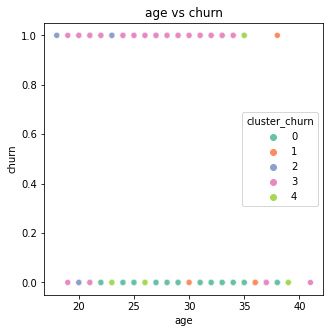

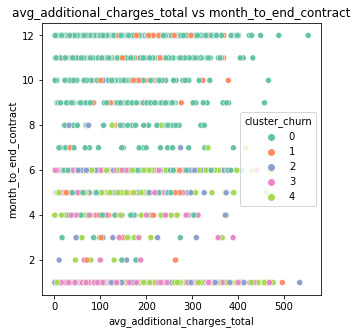

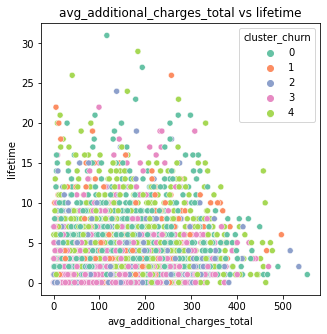

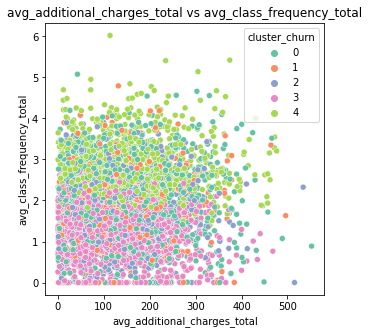

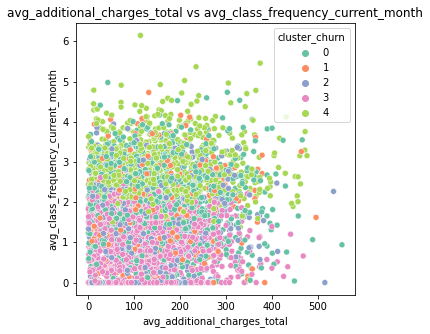

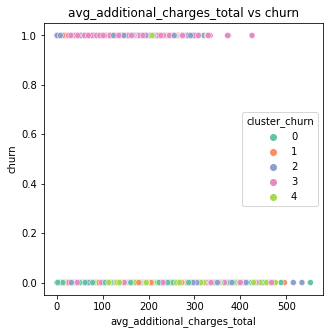

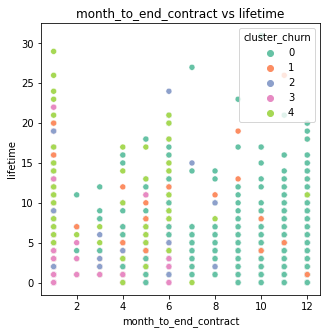

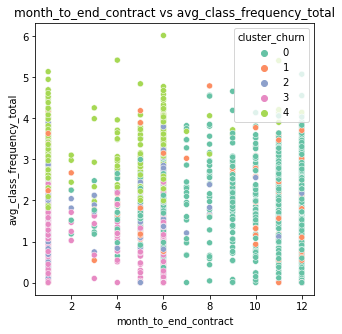

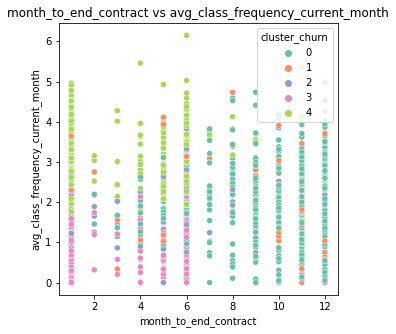

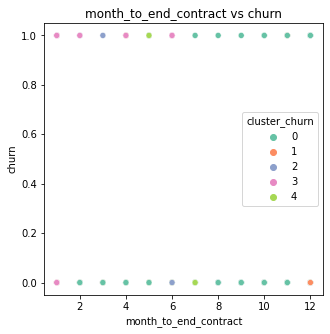

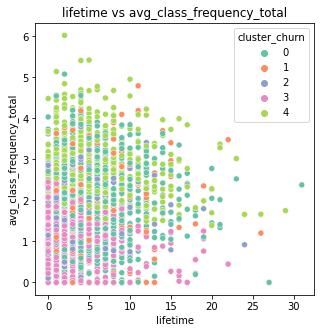

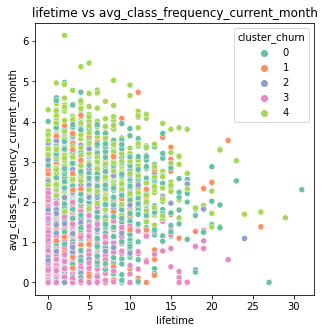

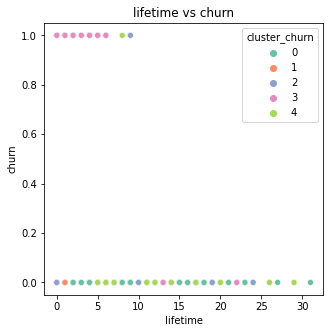

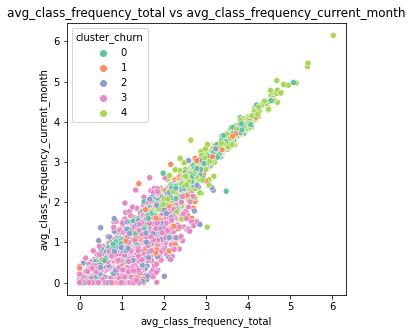

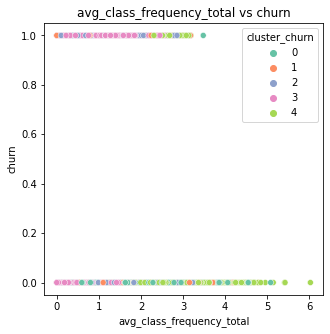

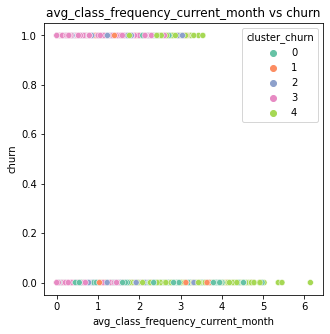

In [33]:
for pair in col_pairs:
    plot_clusters(data_gym, pair[0], pair[1], "cluster_churn")

По построенным графикам хорошо заметно, что признак срок до окончания действия абонемента является одним из "разграничивающих" для кластеров, а также признаки количества посещений (за месяц и по итогу).

#### Отток посетителей в разрезе кластеров

In [34]:
data_gym.groupby("cluster_churn")["churn"].mean() * 100

cluster_churn
0     2.772277
1    26.753247
2    44.356436
3    51.426307
4     6.801909
Name: churn, dtype: float64

Наибольшая доля оттока 51% сложилась в кластере 3, наименьшая в кластере 0.  

Основные характеристики самого рискового кластера:  
- наименьший средний возраст среди остальных кластеров,
- самый короткий период абонемента,
- наименьшее количество визитов в неделю,
- наименьшая сумма трат на дополнительные услуги.  
С большой долей вероятности это посетители либо получившие абонемент в подарок, либо только решившие попробовать такой вид занятий.

Самый надежный устойчивый к оттоку кластер можно считать 0.  
- клиенты имеют самый длительный стаж сотрудничества с фитнес-центром,
- самые длительные по сроку действия абонементы,
- заинтересованность в групповых занятиях,
- одна из самых высоких сумм трат на дополнительные услуги. 

Это постоянные посетители пользующиеся разными видами услуг, оказываемые центром.

## Выводы

По данным проведенного анализа можно сделать следующие выводы:  
- **наиболее заинтересованные и устойчивые к оттоку клиенты**:
    - люди в возрасте 28-32 лет, 
    - пользующиеся дополнительными услугами фитнес-центра, 
    - посещающие дополнительные занятия,
    - приобретающие долгосрочные абонементы 6-12 месяцев.  


- **чтобы предотвратить отток клиентов можно предложить следующие меры**:  
    - увеличить минимальный срок действия с одного месяца до трех, возможно с промо ценой. Это позволит человеку привыкнуть к регулярным занятиям и в последствии пользоваться фитнес-центром постоянно.
    - проводить групповые занятия для целой аудитории по возрасту до 30, старше 35 например.
    - расширить список дополнительных услуг, возможно скорретировать ценообразование на них.